In [1]:
from __future__ import print_function
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
from sklearn import metrics
import seaborn as sns
import tensorflow as tf

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
# from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)

# read csv
train_data = pd.read_csv("./dataSet/train.csv")
test_data = pd.read_csv("./dataSet/test.csv")

test_data_copy = test_data.copy()
train_data_copy = train_data.copy()


In [2]:
# display.display(train_data.describe())
# display.display(train_data.info())

In [3]:
def construct_features(input_data):
    return (set([tf.feature_column.numeric_column(my_feature)
                 for my_feature in input_data]))

In [4]:
def train(train_example, learning_rate, batch_size, steps, periods, mod_dir):
    # Use sample method to seperate train dataset and validation dataset
    train_set = train_example.sample(frac=0.8, replace=False, random_state=100)
    cv_set = train_example.loc[set(train_example.index) - set(train_set.index)]
    feature_columns = construct_features(train_example.drop('SalePrice', axis=1))
    
    # Create train and cv input function
    train_input = tf.estimator.inputs.pandas_input_fn(
        x = train_set.drop('SalePrice', axis=1),
        y = train_set.SalePrice,
        num_epochs=None,
        shuffle=True,
        batch_size=batch_size
    )
    
    train_eval_input = tf.estimator.inputs.pandas_input_fn(
        x = train_set.drop('SalePrice', axis=1),
        y = train_set.SalePrice,
        num_epochs=1,
        shuffle=True,
    )
    
    cv_input = tf.estimator.inputs.pandas_input_fn(
        x = cv_set.drop('SalePrice', axis=1),
        y = cv_set.SalePrice,
        num_epochs=1,
        shuffle=False,
    )
    
    # Declare optimizer for estimator
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 2.5)
    estimator = tf.estimator.DNNRegressor(
        hidden_units=[256, 128, 64],
        feature_columns=feature_columns,
        optimizer=my_optimizer,
        model_dir=mod_dir
    )
    
    training_rmse = []
    validation_rmse = []
    
    for i in range (periods):
        # Train model
        print('%d period:' % (i + 1), end='')
        estimator.train(input_fn=train_input, steps=steps)
        
        # Evaluate model with validation dataset
        eval_cv = estimator.evaluate(input_fn=cv_input)
        print(eval_cv['average_loss'], end=' ')
        
        # Take a break and compute predictions.
        training_predictions = estimator.predict(input_fn=train_eval_input)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        validation_predictions = estimator.predict(input_fn=cv_input)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
        # Compute training and validation loss.
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_predictions, train_set.SalePrice))
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(validation_predictions, cv_set.SalePrice))        
        print("  RMSE : %0.2f, %0.2f" % (training_root_mean_squared_error, validation_root_mean_squared_error))
        
        # Add the loss metrics from this period to our list.
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")

  
    # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()
    
    return estimator
        

In [5]:
def my_stupid_one_hot(data, feature, one_hot_map, feature_map):
    for i in range(len(feature_map)):
        data[feature_map[i]] = data[feature] == one_hot_map[i]
    return data

feature_map = ('ExterQual1', 'ExterQual2', 'ExterQual3', 'ExterQual4')
one_hot_map = ('Gd', 'TA', 'Ex', 'Fa')

train_data = my_stupid_one_hot(train_data, 'ExterQual', one_hot_map, feature_map)
test_data = my_stupid_one_hot(test_data, 'ExterQual', one_hot_map, feature_map)
# display.display(train_data.head(10))

feature_map = ('BsmtQual1', 'BsmtQual2', 'BsmtQual3', 'BsmtQual4')
one_hot_map = ('Gd', 'TA', 'Ex', 'Fa')

train_data = my_stupid_one_hot(train_data, 'BsmtQual', one_hot_map, feature_map)
test_data = my_stupid_one_hot(test_data, 'BsmtQual', one_hot_map, feature_map)


In [6]:
def normalize(series):
    return (series - series.mean()) / series.std()


1 period:3.4669158   RMSE : 2.01, 1.86
2 period:0.5911114   RMSE : 0.94, 0.77
3 period:0.25810698   RMSE : 0.67, 0.51
4 period:0.16525164   RMSE : 0.63, 0.41
5 period:0.10309315   RMSE : 0.60, 0.32
6 period:0.08591546   RMSE : 0.57, 0.29
7 period:0.08968188   RMSE : 0.59, 0.30
8 period:0.07279361   RMSE : 0.61, 0.27
9 period:0.073611364   RMSE : 0.55, 0.27
10 period:0.040748052   RMSE : 0.56, 0.20
11 period:0.07107246   RMSE : 0.53, 0.27
12 period:0.075469345   RMSE : 0.64, 0.27
13 period:0.059171926   RMSE : 0.64, 0.24
14 period:0.055353537   RMSE : 0.49, 0.24
15 period:0.05405401   RMSE : 0.56, 0.23
Model training finished.


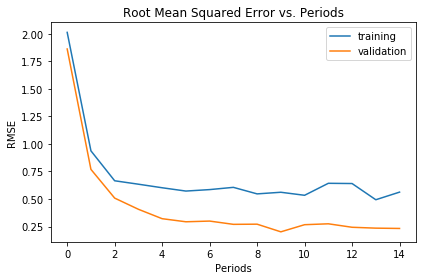

In [10]:
# outlier and missing data
outlier_data_set = pd.DataFrame({
    '1stFlrSF':normalize(train_data['1stFlrSF'].apply(lambda x : min(x, 2500))),
    'GrLivArea':normalize(train_data['GrLivArea'].apply(lambda x : min(x, 3000))),
    'OverallQual':normalize(train_data['OverallQual']),
    'FullBath':normalize(train_data['FullBath']),
    'TotalBsmtSF':normalize(train_data['TotalBsmtSF'].apply(lambda x : min(x, 3000))),
    'BsmtQual1':train_data['BsmtQual1'],
    'BsmtQual2':train_data['BsmtQual2'],
    'BsmtQual3':train_data['BsmtQual3'],
    'BsmtQual4':train_data['BsmtQual4'],
    'SalePrice':np.log(train_data['SalePrice']),
})

estimator = train(
    learning_rate = 0.01,
    batch_size = 10,
    steps = 100,
    periods = 15,
    train_example = outlier_data_set,
    mod_dir='./tensorboard/outlier2/train1'
)

In [12]:
# Final prediction
def test_input(test_example):
    test_input_fn = tf.estimator.inputs.pandas_input_fn(
          x=test_example,
          num_epochs=1, # only to predict
          shuffle=False,
    )
    return test_input_fn

tmp = test_data['TotalBsmtSF'].copy().dropna()
tmp = test_data['TotalBsmtSF'].sum() / len(test_data['TotalBsmtSF'])
test_data['TotalBsmtSF'] = test_data['TotalBsmtSF'].fillna(tmp)
# print(test_simple_example['TotalBsmtSF'].isnull().sum())

tmp = test_data['GarageArea'].copy().dropna()
tmp = test_data['GarageArea'].sum() / len(test_data['GarageArea'])
test_data['GarageArea'] = test_data['GarageArea'].fillna(tmp)

test = pd.DataFrame({
    '1stFlrSF':normalize(test_data['1stFlrSF'].apply(lambda x : min(x, 2500))),
    'GrLivArea':normalize(test_data['GrLivArea'].apply(lambda x : min(x, 2500))),
    'OverallQual':normalize(test_data['OverallQual']),
    'FullBath':normalize(test_data['FullBath']),
    'TotalBsmtSF':normalize(test_data['TotalBsmtSF'].apply(lambda x : min(x, 2500))),
    'BsmtQual1':test_data['BsmtQual1'],
    'BsmtQual2':test_data['BsmtQual2'],
    'BsmtQual3':test_data['BsmtQual3'],
    'BsmtQual4':test_data['BsmtQual4'],
})

# display.display(test_data.info())
final_input = test_input(test)

predictions = list(estimator.predict(input_fn=final_input))
predicted_classes = [math.exp(float(prediction['predictions'][0])) for prediction in predictions]

evaluation = test_data_copy['Id'].copy().to_frame()
evaluation["SalePrice"] = predicted_classes
evaluation.to_csv("evaluation_submission.csv", index=False)
# evaluation["actual"] = train_data.SalePrice
display.display(evaluation.describe())
display.display(evaluation)


,Id,SalePrice
count,1459.000000,1459.000000
mean,2190.000000,201306.788460
std,421.321334,89968.004677
min,1461.000000,13904.655360
25%,1825.500000,143374.680933
50%,2190.000000,180260.371456
75%,2554.500000,233322.999823
max,2919.000000,969744.711397


,Id,SalePrice
0,1461,131728.706408
1,1462,186130.965065
2,1463,179561.198933
3,1464,192636.820372
4,1465,207408.778315
5,1466,205697.976402
6,1467,179498.363784
7,1468,183154.595840
8,1469,204360.353243
9,1470,118262.855635
